In [114]:
import torch
from torch import nn
from torch.utils.data import dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from skimage import color
import matplotlib.pyplot as plt

In [115]:
root_dir = "/tmp"

train_transform = v2.Compose([
	color.rgb2lab,
	v2.Lambda(lambda img: img[:,:,0]),
	v2.Resize((200,200)),
	v2.ToTensor(),
	v2.ToDtype(torch.float32),
])

test_transform = v2.Compose([
	color.rgb2lab,
	v2.Resize((200,200)),
	v2.ToTensor(),
	v2.ToDtype(torch.float32),
])

train_dataset = Flowers102(root=root_dir, split="train", transform=train_transform, download=True)
test_dataset = Flowers102(root=root_dir, split="test", transform=test_transform, download=True)

/home/mmarzloff/Travail/computer_vision/Projet/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Text(0.5, 1.0, 'gray')

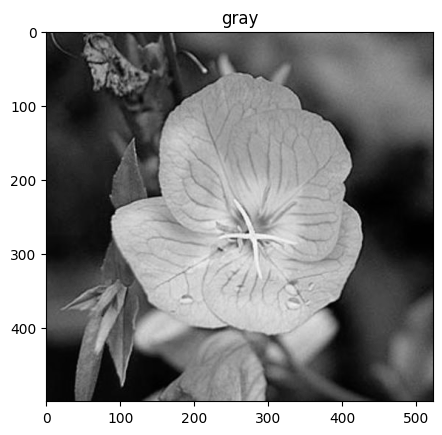

In [116]:
# print("dataset size:",len(test_dataset))
img = test_dataset[0][0]
plt.imshow(img[0,:,:], cmap="gray")
plt.title("gray")
# plt.figure()
# plt.imshow(color.lab2rgb(img))
# plt.title("color")
# plt.tight_layout()

In [119]:
class ColorNN(nn.Module):
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)
	
	def forward(self, X):
		stored = []
		out = self.DoubleConv2d(1, 64, 3)(X)
		stored.append(out.clone())
		out = self.DoubleConv2d(64, 128, 3)(nn.MaxPool2d(2)(out))
		stored.append(out.clone())
		out = self.DoubleConv2d(128, 256, 3)(nn.MaxPool2d(2)(out))
		stored.append(out.clone())
		out = self.DoubleConv2d(256, 512, 3)(nn.MaxPool2d(2)(out))
		out = nn.ConvTranspose2d(512, 256, 2)(out) + v2.CenterCrop(56)(stored.pop())
		out = self.DoubleConv2d(512, 256, 3)(out)
		out = nn.ConvTranspose2d(256, 128, 2)(out) + v2.CenterCrop(56)(stored.pop())
		out = self.DoubleConv2d(256, 128, 3)(out)
		out = nn.ConvTranspose2d(128, 64, 2)(out) + stored.pop()
		return nn.Conv2d(64, 3, 1)(out)
		
	
	def DoubleConv2d(self, c_in, c_out, k_size):
		return nn.Sequential(
			nn.Conv2d(c_in, c_out, k_size),
			nn.ReLU(),
			nn.Conv2d(c_out, c_out, k_size),
			nn.ReLU()
		)

In [120]:
model = ColorNN()

model(train_dataset[0][0])

RuntimeError: The size of tensor a (87) must match the size of tensor b (56) at non-singleton dimension 2